In [249]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import auc, roc_curve, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score, accuracy_score, auc, make_scorer, recall_score, precision_score
import warnings
from scipy import stats
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
import h2o
from h2o.estimators import H2ODeepLearningEstimator

exec(open('utils.py').read())

In [231]:
pd.options.display.float_format = '{:.5f}'.format

## Load Data

In [232]:
df = pd.read_csv('data/Credit_Risk_clean.csv', sep=';').drop(columns= "Unnamed: 0")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.76613,45,2,0.80298,9120.00000,13,0,6,0,2.00000
1,0,0.95715,40,0,0.12188,2600.00000,4,0,0,0,1.00000
2,0,0.65818,38,1,0.08511,3042.00000,2,1,0,0,0.00000
3,0,0.23381,30,0,0.03605,3300.00000,5,0,0,0,0.00000
4,0,0.90724,49,1,0.02493,63588.00000,7,0,1,0,0.00000


In [233]:
X = df.drop("SeriousDlqin2yrs", axis = 1)
y = df["SeriousDlqin2yrs"].to_numpy()
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.76613,45,2,0.80298,9120.00000,13,0,6,0,2.00000
1,0.95715,40,0,0.12188,2600.00000,4,0,0,0,1.00000
2,0.65818,38,1,0.08511,3042.00000,2,1,0,0,0.00000
3,0.23381,30,0,0.03605,3300.00000,5,0,0,0,0.00000
4,0.90724,49,1,0.02493,63588.00000,7,0,1,0,0.00000


## Split dataset

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)
print("X_train dimension : ", X_train.shape)
print("y_train dimension : ", y_train.shape)
print("X_test dimension : ", X_test.shape)
print("y_test dimension : ", y_test.shape)

X_train dimension :  (95810, 10)
y_train dimension :  (95810,)
X_test dimension :  (23953, 10)
y_test dimension :  (23953,)


In [286]:
# export for deep learning
Train = X_train.copy()
Train["SeriousDlqin2yrs"] = y_train
print("Shape : ", Train.shape)
Test = X_test.copy()
Test["SeriousDlqin2yrs"] = y_test
Train.to_csv('data/train_set.csv')
Test.to_csv('data/test_set.csv')

Shape :  (95810, 11)


## Initiate KFold

In [236]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

## Compute Class Weights

In [237]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y= y_train)

weight_dict = {np.unique(y)[i]: weights[i] for i in range(len(np.unique(y)))}
weight_dict

{0: 0.5373166135762035, 1: 7.199428914938383}

## Store our futur results in a dataframe

In [238]:
model_result = pd.DataFrame(columns= ["Model", "Accuracy", "Recall", "F1_score", "AUC"])

## Logistic Regression Benchmark

<string>:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


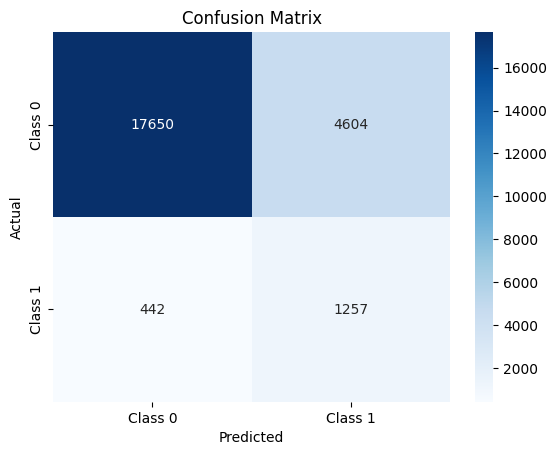

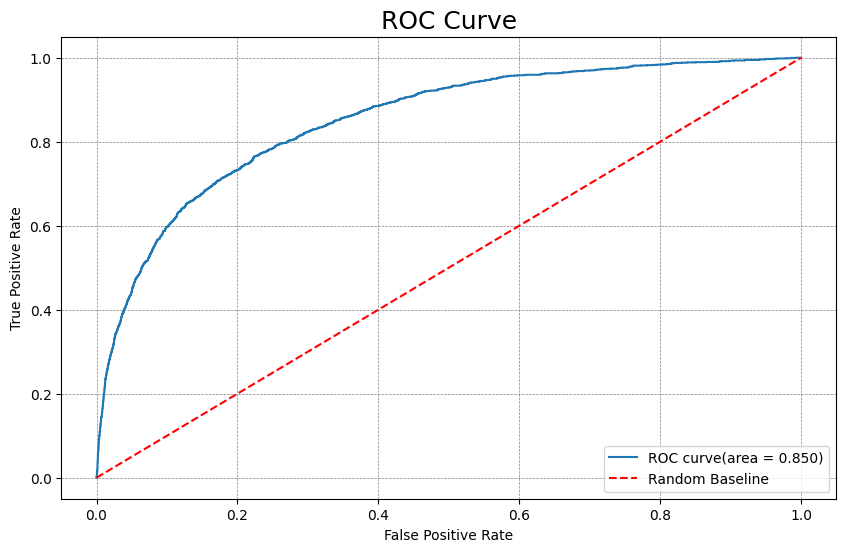

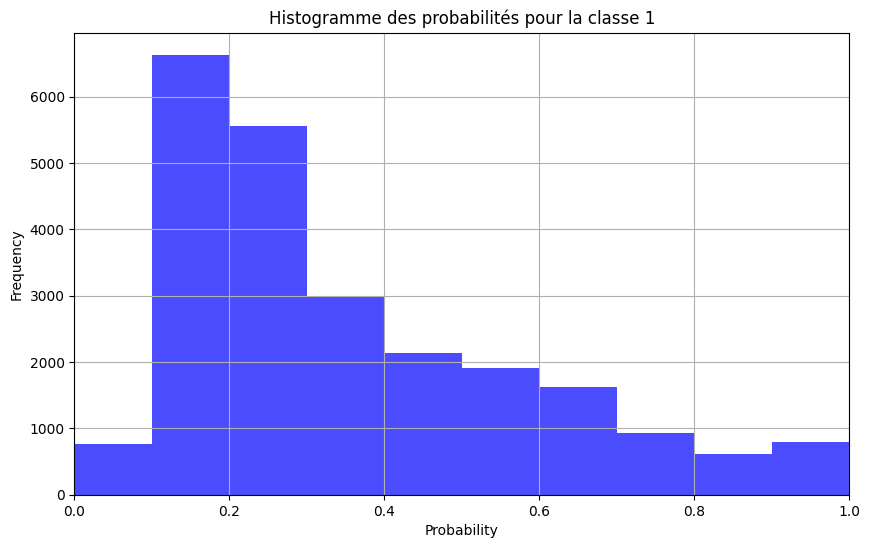

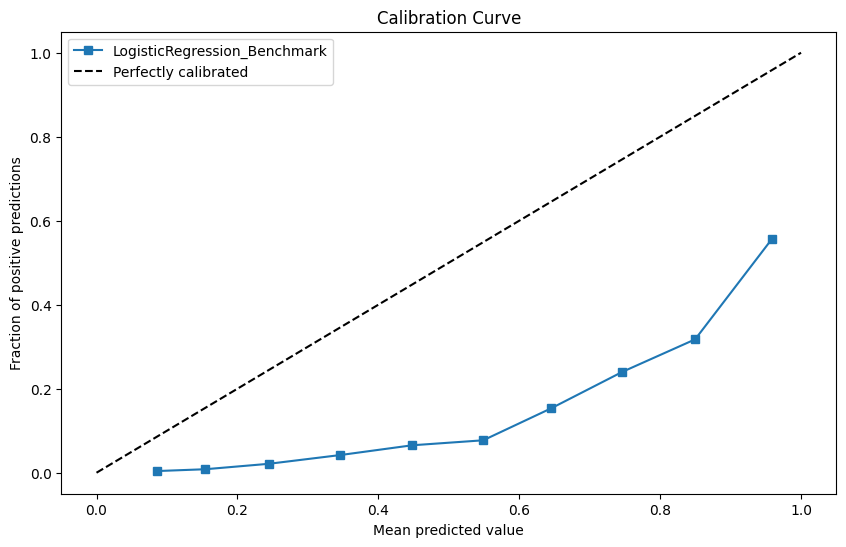

In [239]:
model_result = pipeline_logreg_benchmark(X_train, y_train, X_test, y_test, model_result)

## Logistic Regression : Cross-Validation

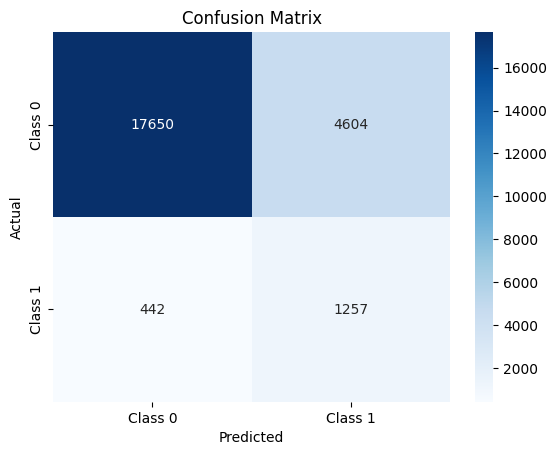

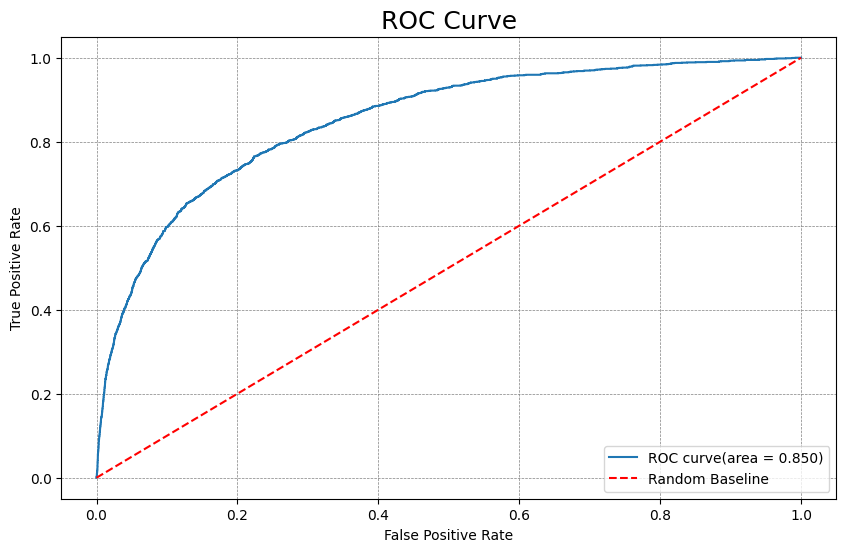

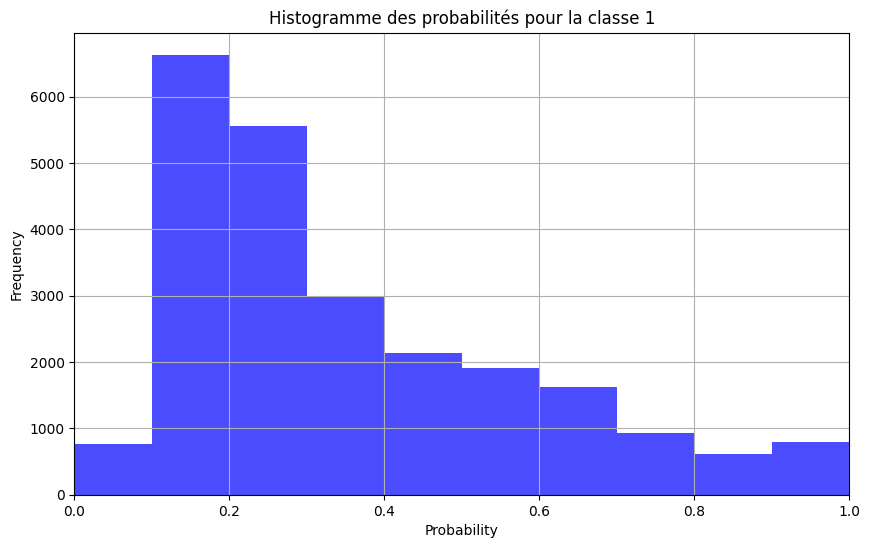

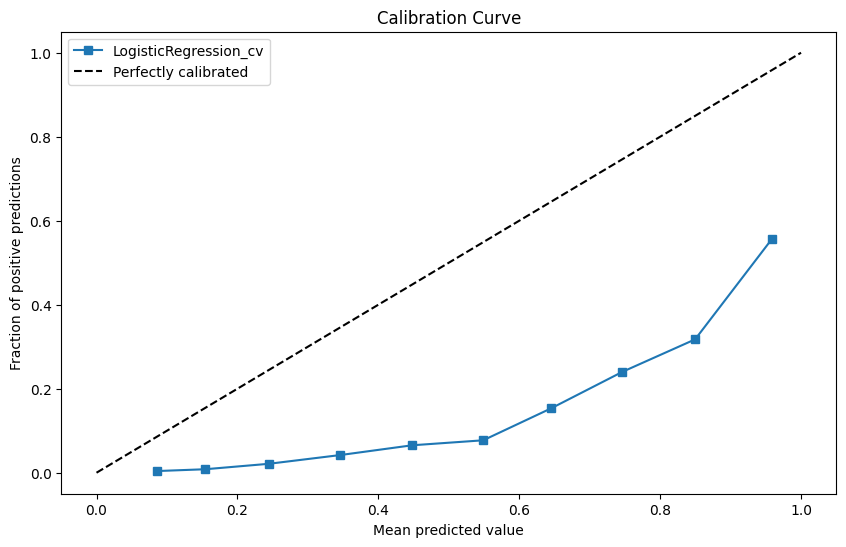

In [240]:
model_result = pipeline_logreg_cv(X_train, y_train, X_test, y_test, model_result)

## Random Forest

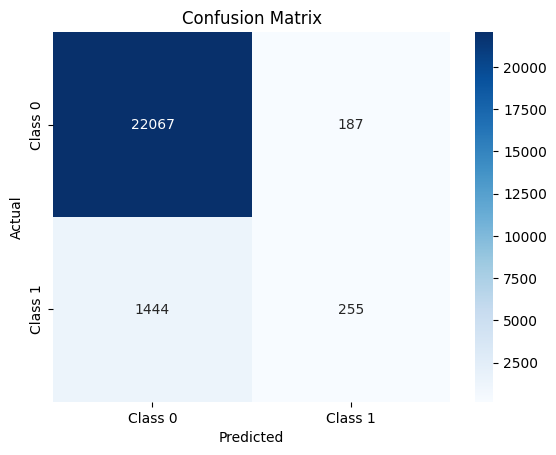

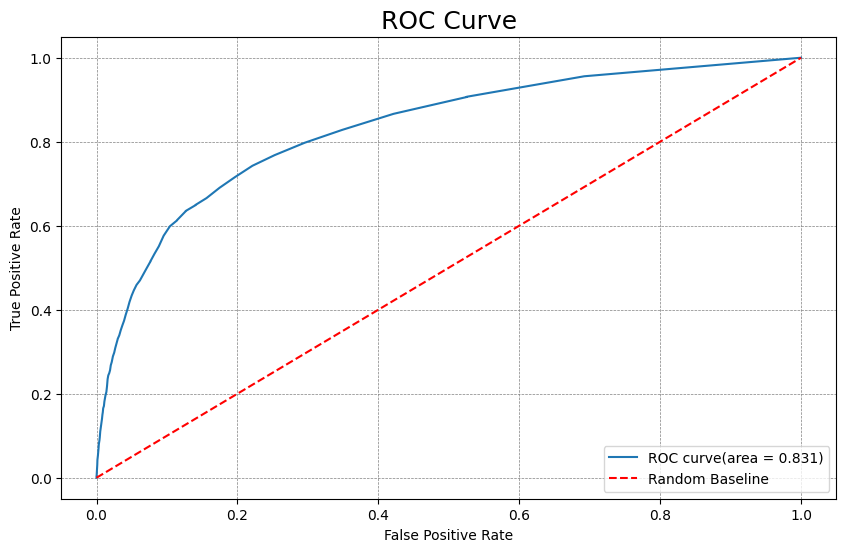

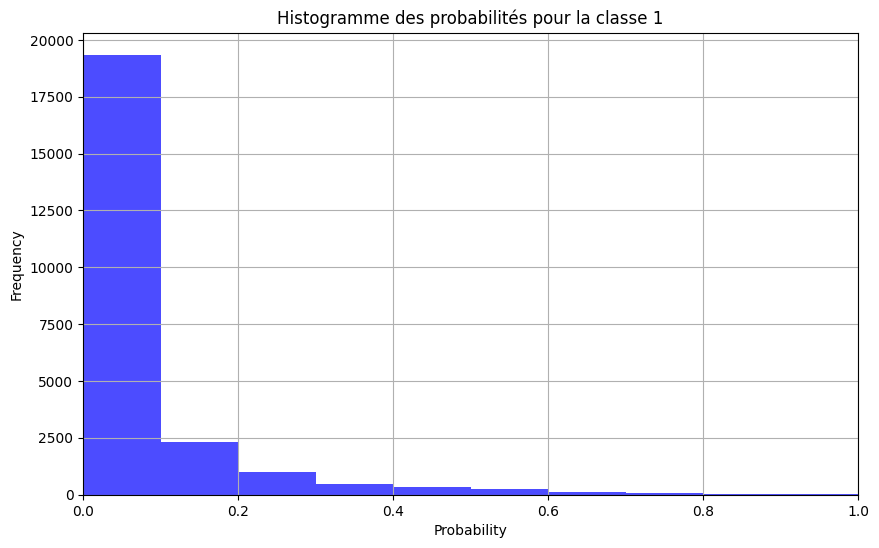

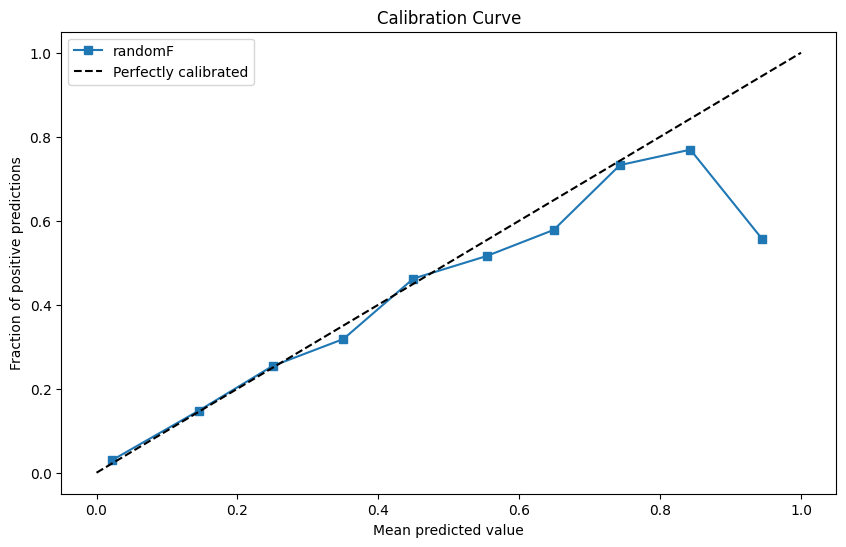

In [241]:
model_result = pipeline_randomF_benchmark(X_train, y_train, X_test, y_test, model_result)

## Random Forest Cross-validation

/Users/alexisrevelle/miniconda3/envs/deepL/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


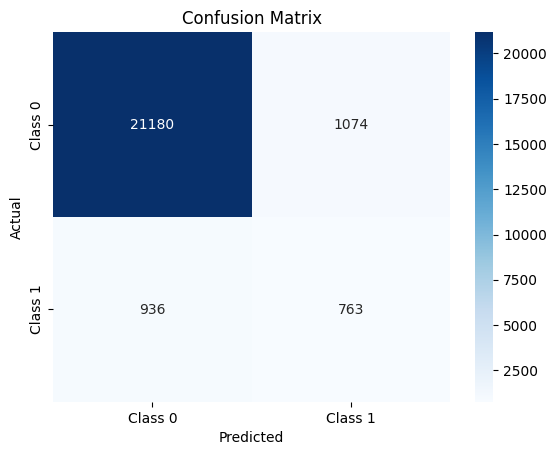

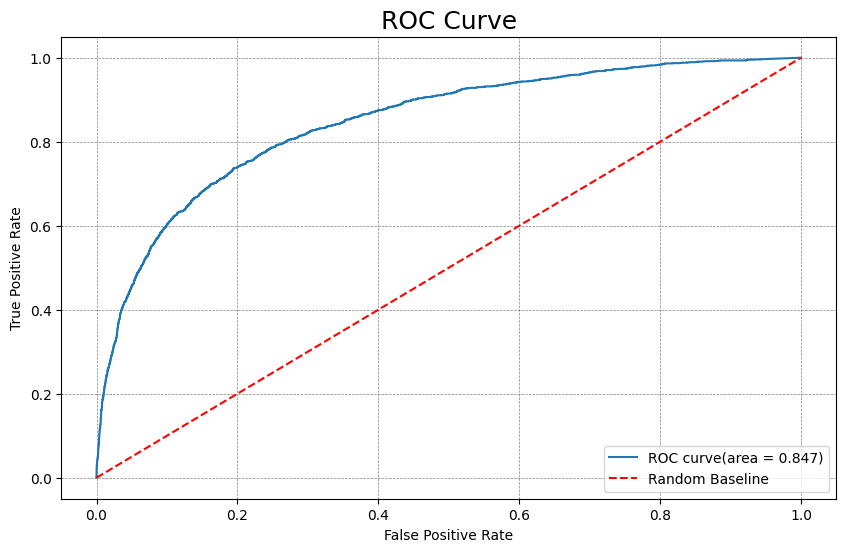

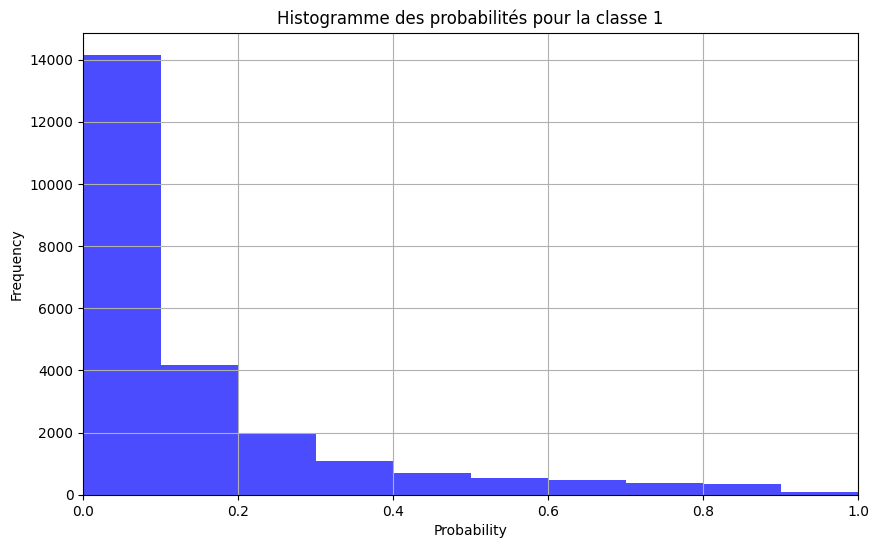

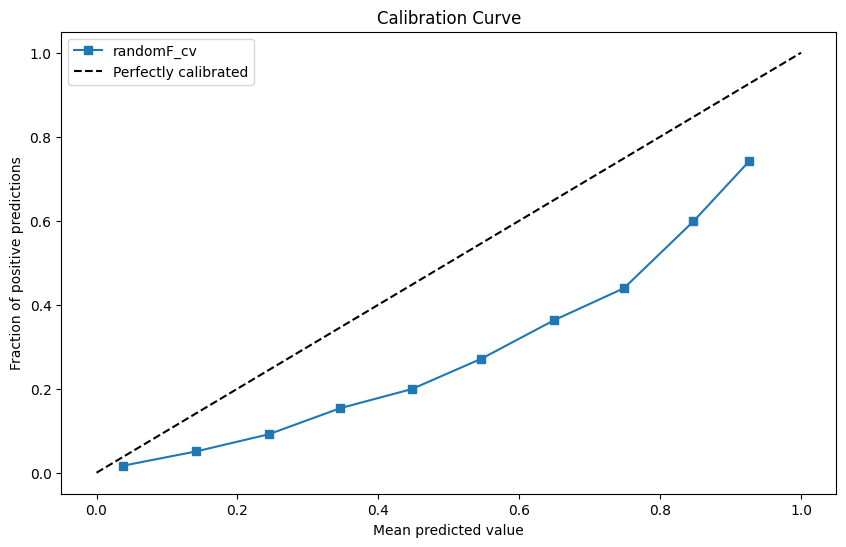

In [242]:
model_result = pipeline_randomF_cv(X_train, y_train, X_test, y_test, model_result)

## XGBoost Benchmark

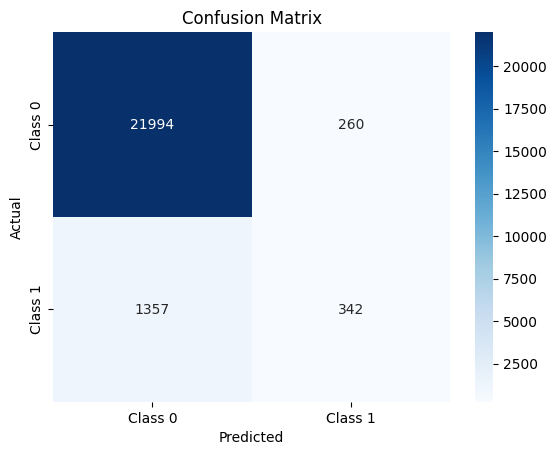

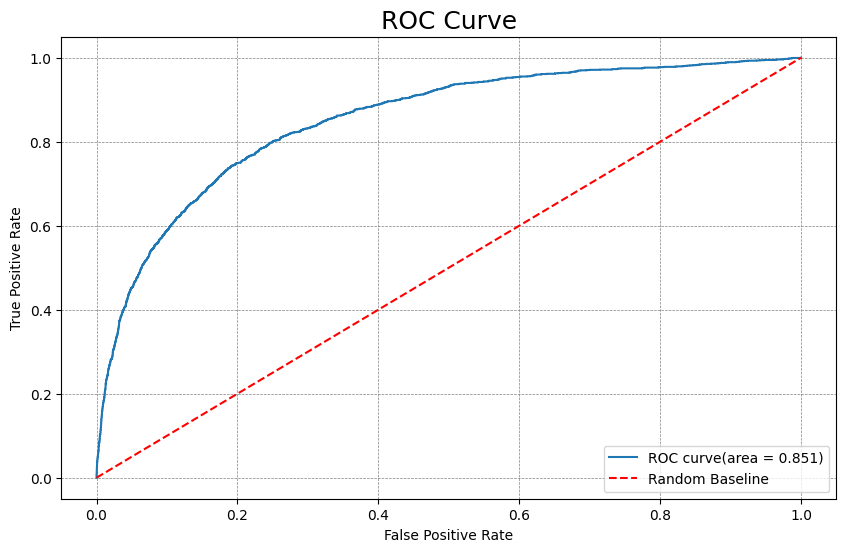

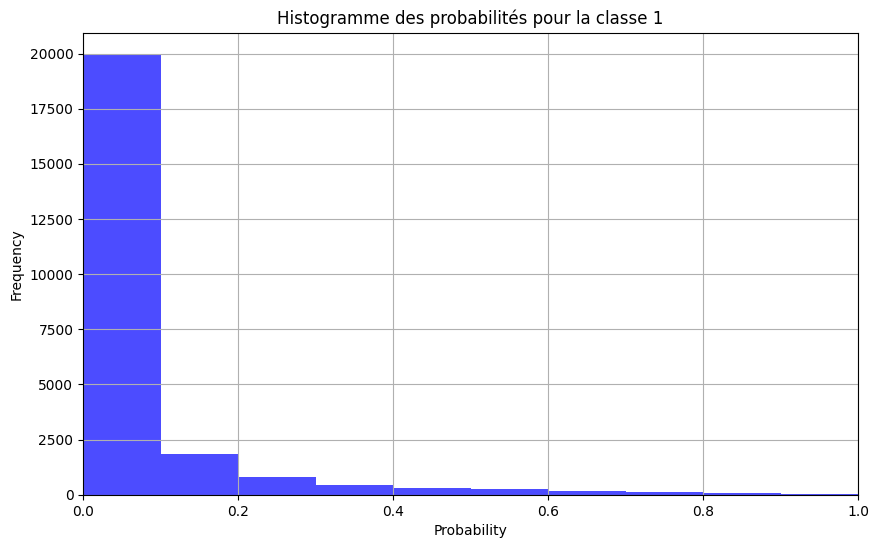

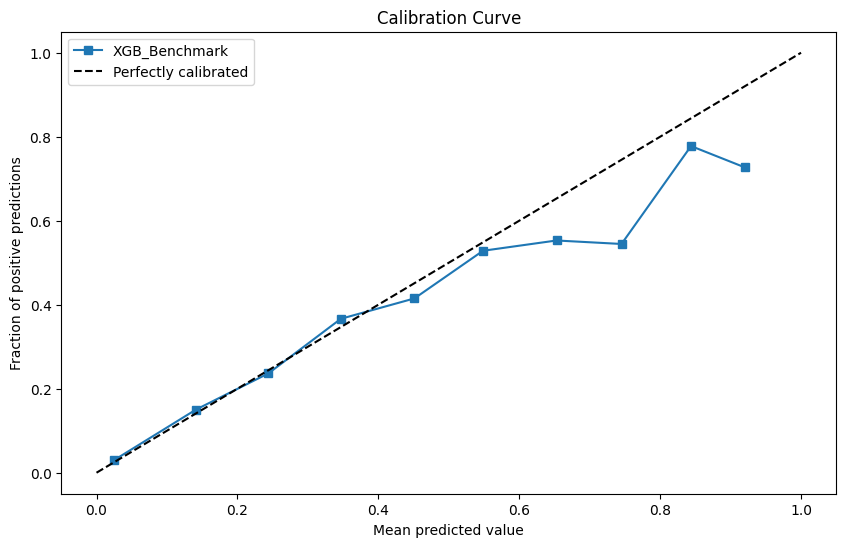

In [243]:
model_result = pipeline_xgb_benchmark(X_train, y_train, X_test, y_test, model_result)

## XGBoost Cross validation

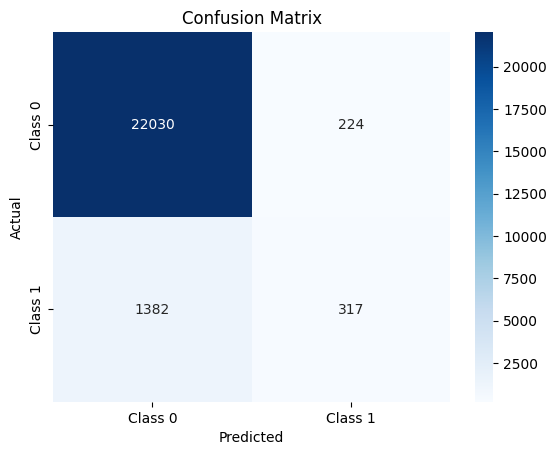

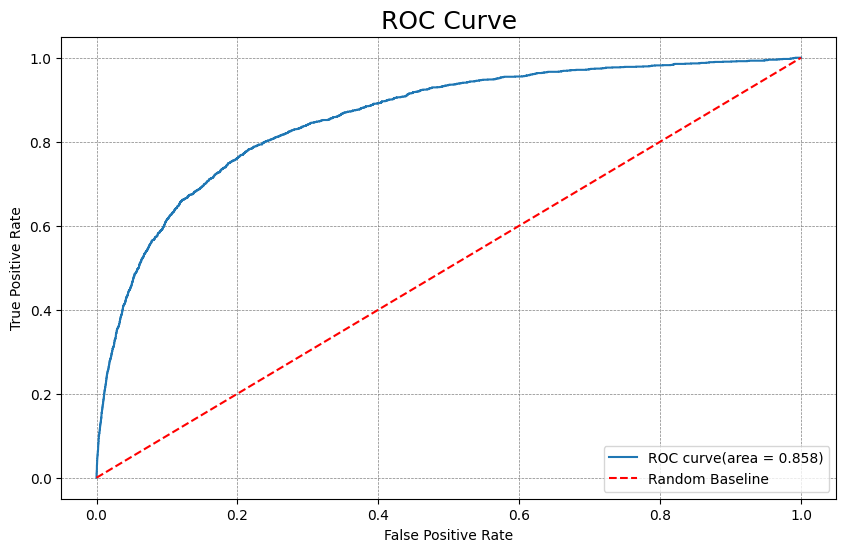

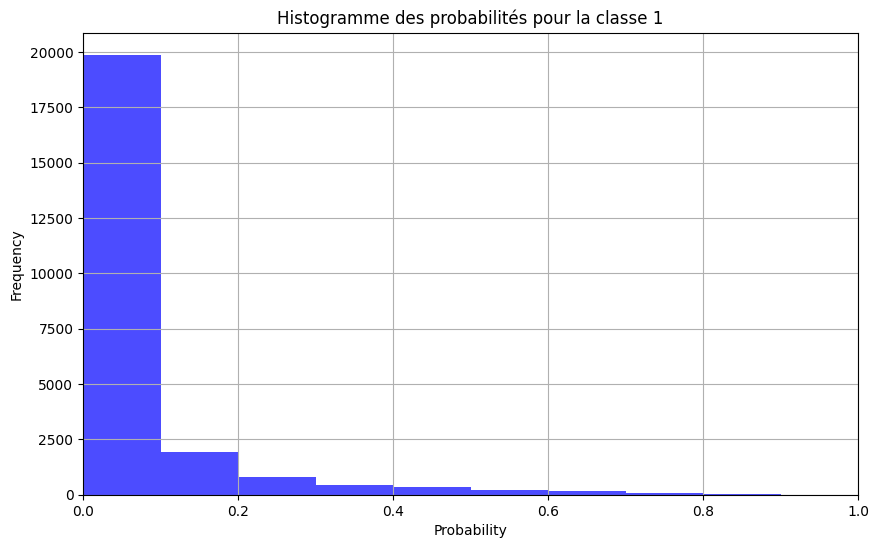

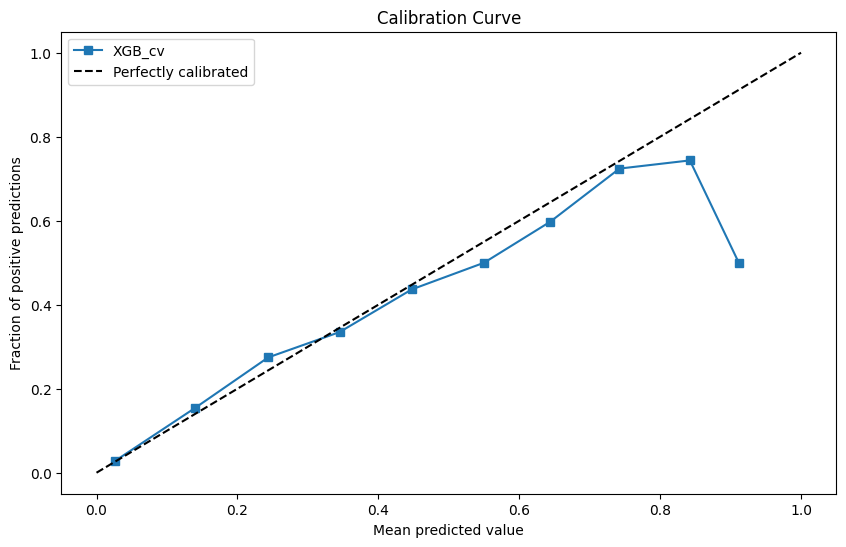

In [244]:
model_result = pipeline_xgb_cv(X_train, y_train, X_test, y_test, model_result)